In [5]:
import torch
from torch import Tensor
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import numpy as np
import torch as t
import tqdm
#functional
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from functools import partial
import einops
import circuitsvis as cv
from alphatoe.game import Board, apply_best_moves, get_best_moves, generate_all_games, tree_walk
from typing import Optional, Any
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Graphing stuff

In [6]:
def to_numpy(tensor: Tensor, flat: bool=False):
    if type(tensor)!=torch.Tensor:
        return tensor
    if flat:
        return tensor.flatten().detach().cpu().numpy()
    else:
        return tensor.detach().cpu().numpy()

def imshow(tensor: Tensor, xaxis: Optional[str]=None, yaxis: Optional[str]=None, animation_name: str='Snapshot', **kwargs: Any):
    tensor = torch.squeeze(tensor)
    px.imshow(to_numpy(tensor, flat=False),aspect='auto', 
              labels={'x':xaxis, 'y':yaxis, 'animation_name':animation_name}, 
              **kwargs).show()
# Set default colour scheme
imshow = partial(imshow, color_continuous_scale='Blues')
# Creates good defaults for showing divergent colour scales (ie with both 
# positive and negative values, where 0 is white)
imshow_div = partial(imshow, color_continuous_scale='RdBu', color_continuous_midpoint=0.0)
# Presets a bunch of defaults to imshow to make it suitable for showing heatmaps 
# of activations with x axis being input 1 and y axis being input 2.
inputs_heatmap = partial(imshow, xaxis='Input 1', yaxis='Input 2', color_continuous_scale='RdBu', color_continuous_midpoint=0.0)

def line(x, y=None, hover=None, xaxis='', yaxis='', **kwargs):
    if type(y)==torch.Tensor:
        y = to_numpy(y, flat=True)
    if type(x)==torch.Tensor:
        x = to_numpy(x, flat=True)
    fig = px.line(x, y=y, hover_name=hover, **kwargs)
    fig.update_layout(xaxis_title=xaxis, yaxis_title=yaxis)
    fig.show()
def lines(lines_list, x=None, mode='lines', labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, **kwargs):
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show()

# Training Config Stuff

In [7]:
cfg = HookedTransformerConfig(
    n_layers = 8,
    n_heads = 8,
    d_model = 128,
    d_head = 16,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=11,
    d_vocab_out=10,
    n_ctx=10,
    init_weights=True,
    device="cuda",
    seed = 1337,
)

lr = 1e-5
weight_decay = 1e-4
test_train_split = 0.8
epochs = 50
batch_size = 8192


#     normalization_type='LN',
#     d_vocab=11,
#     d_vocab_out=10,
#     n_ctx=10,
#     init_weights=True,
#     device="cuda",
#     seed = 1337,
# )

# lr = 1e-5
# weight_decay = 1e-4
# test_train_split = 0.8
# epochs = 40
# batch_size = 8192

In [3]:
boards = [Board()]
game_list = apply_best_moves(boards)

In [4]:
len(game_list)

3584

In [4]:
[game.moves_played for game in game_list]

[[0, 4, 1, 2, 6, 3, 5, 7, 8],
 [0, 4, 1, 2, 6, 3, 5, 8, 7],
 [0, 4, 2, 1, 7, 3, 5, 8, 6],
 [0, 4, 2, 1, 7, 5, 3, 6, 8],
 [0, 4, 2, 1, 7, 6, 3, 5, 8],
 [0, 4, 2, 1, 7, 6, 3, 8, 5],
 [0, 4, 2, 1, 7, 6, 5, 8, 3],
 [0, 4, 2, 1, 7, 6, 8, 5, 3],
 [0, 4, 2, 1, 7, 8, 3, 6, 5],
 [0, 4, 2, 1, 7, 8, 5, 3, 6],
 [0, 4, 2, 1, 7, 8, 5, 6, 3],
 [0, 4, 2, 1, 7, 8, 6, 3, 5],
 [0, 4, 3, 6, 2, 1, 7, 5, 8],
 [0, 4, 3, 6, 2, 1, 7, 8, 5],
 [0, 4, 5, 1, 7, 6, 2, 8, 3],
 [0, 4, 5, 1, 7, 8, 2, 3, 6],
 [0, 4, 5, 1, 7, 8, 2, 6, 3],
 [0, 4, 5, 1, 7, 8, 3, 6, 2],
 [0, 4, 5, 1, 7, 8, 6, 3, 2],
 [0, 4, 5, 2, 6, 3, 1, 7, 8],
 [0, 4, 5, 2, 6, 3, 1, 8, 7],
 [0, 4, 5, 2, 6, 3, 7, 8, 1],
 [0, 4, 5, 2, 6, 3, 8, 7, 1],
 [0, 4, 5, 7, 1, 2, 6, 3, 8],
 [0, 4, 5, 8, 1, 2, 6, 3, 7],
 [0, 4, 5, 8, 2, 1, 7, 3, 6],
 [0, 4, 5, 8, 2, 1, 7, 6, 3],
 [0, 4, 5, 8, 6, 3, 1, 2, 7],
 [0, 4, 5, 8, 6, 3, 2, 1, 7],
 [0, 4, 5, 8, 6, 3, 7, 1, 2],
 [0, 4, 5, 8, 6, 3, 7, 2, 1],
 [0, 4, 5, 8, 7, 1, 2, 3, 6],
 [0, 4, 5, 8, 7, 1, 2, 6, 3],
 [0, 4, 5,

In [2]:
board = Board()

In [3]:
get_best_moves(board)


[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [4]:
board.get_possible_moves()

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [16]:
board.make_move(2)
board.draw_board()

| O | X | O |
|   | X |   |
|   |   |   |


In [24]:
board.moves_played

[1, 3, 5, 6, 0, 4]

In [11]:
print(game_list[3].moves_played)

[0, 1, 3, 7, 6]


In [7]:
boards = [Board()]
game_list = apply_best_moves(boards)
moves = np.array([[10] + game.moves_played + [9] for game in game_list])

KeyboardInterrupt: 

In [13]:
boards = [Board()]
game_list = generate_all_games(boards)
moves = np.array([[10] + game.moves_played + ([9] * (cfg.n_ctx - len(game.moves_played))) for game in game_list])

In [7]:
print(moves[0])

[10  0  1  3  2  6  9  9  9  9  9]


In [20]:
boards = [Board()]
game_list = apply_best_moves(boards)
moves = np.array([game.moves_played + [9] for game in game_list])

we're on the 1th loop!


ValueError: Not a valid move nerd!!

In [14]:
#load npy file
# np_data = np.load('data/moves.npy')
data = moves[:, :-1]
labels = moves[:, 1:]

print(len(data))
print(len(labels))
print(data[0])
print(labels[0])

255168
255168
[10  0  1  3  2  6  9  9  9  9]
[0 1 3 2 6 9 9 9 9 9]


In [15]:
#data and labels as numpy arrays
encoded_labels: Tensor = F.one_hot(t.tensor(labels))
data = np.array(data)
encoded_labels = np.array(encoded_labels)
#data and encoded_labels as tensors
data = t.from_numpy(data)
encoded_labels = t.from_numpy(encoded_labels).to(t.float)
total_data = list(zip(data, encoded_labels))
num_samples = len(total_data)
train_size = int(test_train_split * num_samples)
test_size = num_samples - train_size
split_data = list(t.utils.data.random_split(total_data, [train_size, test_size]))
train_pairs = split_data[0]
test_pairs= split_data[1]
train_data, train_labels = zip(*train_pairs)
test_data, test_labels = zip(*test_pairs)

train_data = t.stack(train_data).to(cfg.device)
train_labels = t.stack(train_labels).to(cfg.device)
test_data = t.stack(test_data).to(cfg.device)
test_labels = t.stack(test_labels).to(cfg.device)



#test train split
train_data = data[:int(len(data)*test_train_split)]
train_labels = encoded_labels[:int(len(data)*test_train_split)]
test_data = data[int(len(data)*test_train_split):]
test_labels = encoded_labels[int(len(data)*test_train_split):]

In [16]:
def loss_fn(logits: Tensor, labels: Tensor):
    return t.nn.functional.cross_entropy(logits, labels)

In [20]:
def seq_is_matched(input: list[int], seq: list[int]) -> bool:
    return all(seq[i] == input[i] for i in range(len(seq)))

In [21]:
[seq for seq in seqs if seq_is_matched(seq, [4])]

NameError: name 'seqs' is not defined

In [17]:
train_losses = []
test_losses = []
# ALPHATOE
model = HookedTransformer(cfg).to(cfg.device)
optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# for epoch in tqdm.tqdm(range(epochs)):
for epoch in range(epochs):
    for batch in range(0, len(train_data), batch_size):
        train_logits = model(train_data[batch:batch+batch_size])
        train_loss = loss_fn(train_logits, train_labels[batch:batch+batch_size])

        train_loss.backward()

        train_losses.append(train_loss.item())
        optimizer.step()
        optimizer.zero_grad()

        with t.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

        print(f"Epoch {epoch} | Train Loss: {train_loss.item()} | Test Loss: {test_loss.item()}")

Moving model to device:  cuda
Epoch 0 | Train Loss: 2.809720993041992 | Test Loss: 2.7057554721832275
Epoch 0 | Train Loss: 2.709939956665039 | Test Loss: 2.6214585304260254
Epoch 0 | Train Loss: 2.6275126934051514 | Test Loss: 2.5577471256256104
Epoch 0 | Train Loss: 2.5600898265838623 | Test Loss: 2.5083353519439697
Epoch 0 | Train Loss: 2.5101170539855957 | Test Loss: 2.468353271484375
Epoch 0 | Train Loss: 2.4703221321105957 | Test Loss: 2.434781074523926
Epoch 0 | Train Loss: 2.4407336711883545 | Test Loss: 2.406076431274414
Epoch 0 | Train Loss: 2.4066998958587646 | Test Loss: 2.380523204803467
Epoch 0 | Train Loss: 2.383831739425659 | Test Loss: 2.3570046424865723
Epoch 0 | Train Loss: 2.358985185623169 | Test Loss: 2.3352038860321045
Epoch 0 | Train Loss: 2.333693027496338 | Test Loss: 2.3150100708007812
Epoch 0 | Train Loss: 2.3151962757110596 | Test Loss: 2.2963321208953857
Epoch 0 | Train Loss: 2.2956178188323975 | Test Loss: 2.278759717941284
Epoch 0 | Train Loss: 2.2790126

In [ ]:
train_labels[0]

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [37]:
seq_test = [10,3,1,7]
print(t.max(model(t.tensor(seq_test))[0, -1]))
print(t.argmax(model(t.tensor(seq_test))[0, -1]))
print(model(t.tensor(seq_test))[0, -1].shape)



tensor(20.2244, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3, device='cuda:0')
torch.Size([10])


In [20]:
lines([test_losses, train_losses])

(0.0, 100.0)

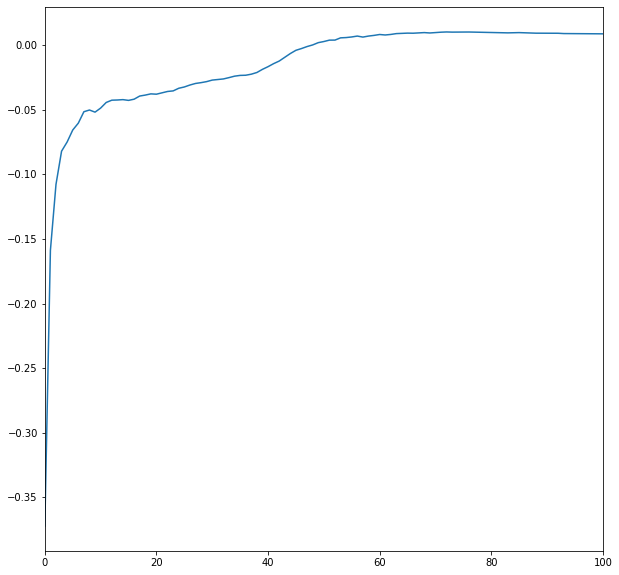

In [ ]:
#difference of lists test_losses and train_losses
diff = [test_losses[i] - train_losses[i] for i in range(len(test_losses))]
plt.figure(figsize=(10, 10))
plt.plot(diff)
#xlim
plt.xlim(0, 100)

In [91]:
seq = t.tensor([10] * 10).to(cfg.device)
out = model(seq)

In [92]:
out[:,-1,:]

tensor([[  13.0404,   60.2860, -115.6297,   50.0891,  -59.7190,  -54.6353,
          -29.3990,    9.6894,  -41.1484,  -44.5379]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
line(test_losses, log_y=True)
# plt.plot(train_losses)

In [ ]:
line(train_losses, log_y=True)

In [22]:
imshow(model.embed.W_E)

In [85]:
# Take the dot product of all the embedding vectors
emb = model.embed.W_E
vec_count = emb.shape[0]
vec_dim = emb.shape[1]
print(f"The embedding shape is {emb.shape}, so our vectors of length {emb.shape[1]}")

dot_products = einops.einsum(emb, emb, "v2 embs, v1 emb -> v1 v2")

The embedding shape is torch.Size([11, 128]), so our vectors of length 128


In [86]:
print(dot_products.shape)
imshow_div(dot_products)

torch.Size([11, 11])


## What would your hypothesis around the attention head activations be based on seeing this?
+ Jack - My poorly informed guess is that tokens with low dot products and/or low norms won't have any strong attentional interaction
+ Omar - I think that corner moves [0, 2, 6, 8] will have similar attention patterns
+ Ari - I think same as Omar, plus center attends to everything, middle edges have attention symmetry too

In [87]:
# tokens = [10,0,2]
tokens = [10] + [1,2,5,8,7]
str_tokens = [str(token) for token in tokens]
logits, cache = model.run_with_cache(torch.tensor(tokens).to('cuda'), remove_batch_dim=True)

print(type(cache))
attention_pattern = cache["pattern", 3, "attn"]
print(attention_pattern.shape)
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([8, 6, 6])


In [18]:
# def generate_sequence(model: HookedTransformer, seq: Optional[list[int]]= None, temperature: float = 1) -> list[int]:
#     if seq == None:
#         seq = [10]
#     assert temperature != 0
#     model_seq = torch.tensor(seq)
#     logit: Tensor = model(model_seq)[0,-1]
#     probabilities: Tensor = torch.softmax(logit/temperature, dim=0)
#     new_token: int = int(torch.multinomial(probabilities, 1).item())
#     seq = seq + [new_token]
#     if new_token == 9 or len(seq) == 10:
#         return seq
#     else:
#         return generate_sequence(model, seq)
        
# def check_sequence(sequence: list[int]) -> bool:
#     board = Board()
#     seq_len = len(sequence)
#     if sequence[-1] != 9:
#         return False
#     dedup_len = len({token for token in sequence})



In [112]:
a = {1,2}
print(len(a))

2


In [107]:
output = generate_sequence(model)

In [106]:
output

[10, 3, 1, 1, 3, 7, 0, 6, 3, 6]

In [96]:
model([1,2,3])

AssertionError: Must provide a tokenizer if passing a string to the model

In [90]:
type(model)

transformer_lens.HookedTransformer.HookedTransformer

In [2]:
board = Board()

In [3]:
out = tree_walk(board)

In [4]:
outb

589325.3191094658

In [5]:
np.log2(500000)

18.931568569324174

In [24]:
def sample_game(model: HookedTransformer, temp: float) -> list[int]:
    assert temp > 0
    seq = [10]
    #no grad
    with t.no_grad():
        for _ in range(8):
            logits = model(t.tensor(seq))[0, -1]
            probs = t.softmax(logits / temp, dim=0)
            token = t.multinomial(probs, num_samples=1).item()
            seq.append(token)
    return seq

def sample_games(model: HookedTransformer, temp: float, num_games: int) -> list[list[int]]:
    games=[]
    for _ in tqdm.tqdm(range(num_games)):
        games.append(sample_game(model, temp))
    return games

all_games_samples = sample_games(model, temp=1, num_games=1000)

100%|██████████| 1000/1000 [00:24<00:00, 41.30it/s]


In [28]:
def check_illegal_moves(game: list[int]) -> bool:
    clean_game = [token for token in game if token != 9]
    set_length = len(set(clean_game))
    return set_length == len(clean_game)

def check_illegal_moves_again(games: list[list[int]]) -> list[bool]:
    return [check_illegal_moves(game) for game in games]
    
def error_rate(games: list[list[int]]) -> float:
    return check_illegal_moves_again(games).count(False) / len(games)

In [29]:
print(f"Error rate for new model: {error_rate(all_games_samples)}")

Error rate for new model: 1.0
